In [1]:
# CORE LIBRARIES
import os
import re
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP LIBRARIES
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# SKLEARN (Traditional ML)
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# DEEP LEARNING (TensorFlow)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional,SimpleRNN,LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# UTILITIES
import joblib  # for saving trained models

# CONFIGURATION
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

warnings.filterwarnings("ignore")


In [2]:
# Load dataset
df_sentiment = pd.read_csv(
    'Sentiment.csv',
    encoding='utf-8-sig',   # Supports Bangla + English
    sep=';',                # Correct separator for your file
    on_bad_lines='skip'     # Skip malformed rows safely
)


df_sentiment.head()

,id,text,label,score,lan,domain
0,2283,Your are very good. keep it up,1,1,EN,funny_video
1,2286,চাকিপ ক্যানের মুবি রিব্যু বেচি বেচি,1,0,BN,funny_video
2,2289,আপনি বাংলাদেশী এইটা সত্যি অবাক করার বিষয়,1,0,BN,funny_video
3,2296,নতুন নতুন সিমেনার চাই,1,0,BN,funny_video
4,2300,Eto buddhi kibhabe shomvob,2,1,RN,funny_video


In [3]:
# Check dataset structure
df_sentiment.info()

# Dataset shape
df_sentiment.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8910 entries, 0 to 8909
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8910 non-null   int64 
 1   text    8910 non-null   object
 2   label   8910 non-null   int64 
 3   score   8910 non-null   int64 
 4   lan     8910 non-null   object
 5   domain  8910 non-null   object
dtypes: int64(3), object(3)
memory usage: 417.8+ KB


(8910, 6)

In [4]:
# Label distribution
df_sentiment['label'].value_counts()

label
1    5024
2    3886
Name: count, dtype: int64

In [5]:
# Score distribution
df_sentiment['score'].value_counts()

score
 0    2805
 1    2688
-1    2660
 2     416
-2     341
Name: count, dtype: int64

In [6]:
# Language distribution
df_sentiment['lan'].value_counts()

lan
RN    3724
BN    2797
EN    2389
Name: count, dtype: int64

In [7]:
# Domain distribution
df_sentiment['domain'].value_counts()

domain
talkshow_video    1615
music_video       1402
review_video      1231
drama_video       1188
news_video        1122
funny_video       1080
sports_video       737
report_video       535
Name: count, dtype: int64

In [8]:
# Remove duplicate rows 
df_sentiment = df_sentiment.drop_duplicates().reset_index(drop=True)

In [9]:
# Drop unnecessary columns 
df_sentiment = df_sentiment.drop(columns=['id', 'domain'], errors='ignore')

In [11]:
# Text Preprocessing

# Download required NLTK data (tokenizer + stopwords)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Stopwords

# English stopwords
stop_en = set(stopwords.words('english'))

# Bangla stopwords
try:
    stop_bn = set(stopwords.words('bengali'))
except:
    stop_bn = set()


# Romanized Bangla stopwords (dataset-specific)
stop_rn = {
    'ami','tumi','amra','na','ta','ki','tomra','tara','ar','je','jeta','kintu','karon','ekhane','ekhono',
    'ekhon','ta','tar','tao','onek','ar','abar','korbo','korche','korlam','korte',
    'nai','hoy','hoye','ache','se','jeta','tao','tomra','tumi',
    'vai','e','kotha','u','bro','ai','ke','onek','k','eto'
}


# Text Cleaning Function
def clean_text(text):
    """Clean text: remove URLs, hashtags, punctuations, normalize spaces."""
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)  # URLs
    text = re.sub(r'@\w+|#\w+', ' ', text)              # mentions, hashtags
    text = re.sub(r'[^\u0980-\u09FFA-Za-z\s]', ' ', text)  # Keep only Bangla & English letters
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Preprocessing Function
stemmer = PorterStemmer()

def preprocess_text(text, lang=None):
    """Tokenize, remove stopwords for English/Bangla/Romanized, stem English."""
    text = clean_text(text)
    tokens = word_tokenize(text)
    lang = (lang or '').upper()

    if lang == 'BN':  # Bangla
        tokens = [t for t in tokens if t not in stop_bn and len(t) > 1]  # remove short words
    elif lang == 'EN':  # English
        tokens = [stemmer.stem(t) for t in tokens if t not in stop_en and len(t) > 2]
    else:  # Romanized Bangla
        tokens = [t for t in tokens if t not in stop_rn and len(t) > 1]

    return ' '.join(tokens)


# Apply Preprocessing
df_sentiment['clean_text'] = df_sentiment.apply(
    lambda r: preprocess_text(r['text'], r['lan']), axis=1
)

# Drop empty cleaned texts
df_sentiment = df_sentiment[df_sentiment['clean_text'].str.strip() != ''].reset_index(drop=True)

# Normalize labels
df_sentiment['label'] = df_sentiment['label'].astype(int)
df_sentiment['score'] = df_sentiment['score'].astype(int)

df_sentiment.head(10)


,text,label,score,lan,clean_text
0,Your are very good. keep it up,1,1,EN,good keep
1,চাকিপ ক্যানের মুবি রিব্যু বেচি বেচি,1,0,BN,চাকিপ ক্যানের মুবি রিব্যু বেচি বেচি
2,আপনি বাংলাদেশী এইটা সত্যি অবাক করার বিষয়,1,0,BN,বাংলাদেশী এইটা সত্যি অবাক বিষয়
3,নতুন নতুন সিমেনার চাই,1,0,BN,সিমেনার চাই
4,Eto buddhi kibhabe shomvob,2,1,RN,buddhi kibhabe shomvob
5,Osthir,2,1,EN,osthir
6,I think this one is the best of all :-D,2,2,EN,think one best
7,I enjoy your videos a lot but you had to watch...,2,1,EN,enjoy video lot watch mani bangla cinema make ...
8,হালা গোরা হালা,1,-1,BN,হালা গোরা হালা
9,সুপার দুপার,1,1,BN,সুপার দুপার


In [12]:
# Filter dataset for 3-label sentiment classification (label == 1)
df_sentiment_3label=df_sentiment[df_sentiment['label']==1]
df_sentiment_3label.shape

(4492, 5)

In [13]:
# Filter dataset for 5-label sentiment classification (label == 2)
df_sentiment_5label=df_sentiment[df_sentiment['label']==2]
df_sentiment_5label.shape

(3649, 5)

In [14]:
# Check class balance 
print("\nLabel3 class balance:\n",df_sentiment_3label['score'].value_counts(normalize=True))
print("\nLabel5 class balance:\n", df_sentiment_5label['score'].value_counts(normalize=True))



Label3 class balance:
 score
 1    0.370214
-1    0.315227
 0    0.314559
Name: proportion, dtype: float64

Label5 class balance:
 score
 0    0.311866
-1    0.271855
 1    0.219512
 2    0.107153
-2    0.089614
Name: proportion, dtype: float64


## --------------------------------------- MODELING : Label 3 ---------------------------------------


In [15]:
# Features and labels
X_sentiment_label3 = df_sentiment_3label['clean_text'] 
y_sentiment_label3 = df_sentiment_3label['score']

In [16]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X_sentiment_label3, y_sentiment_label3, test_size=0.2, random_state=42, stratify=y_sentiment_label3)

In [17]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=8000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


## Classical ML Models


In [18]:
# Logistic Regression
logreg_3 = LogisticRegression(max_iter=200, random_state=SEED)
logreg_3.fit(X_train_vec, y_train)
y_pred_log_3 = logreg_3.predict(X_test_vec)
acc_log_3 = accuracy_score(y_test, y_pred_log_3)



Logistic Regression Accuracy (3-label): 0.6273637374860956
              precision    recall  f1-score   support

          -1       0.57      0.65      0.61       283
           0       0.57      0.48      0.52       283
           1       0.73      0.73      0.73       333

    accuracy                           0.63       899
   macro avg       0.62      0.62      0.62       899
weighted avg       0.63      0.63      0.63       899



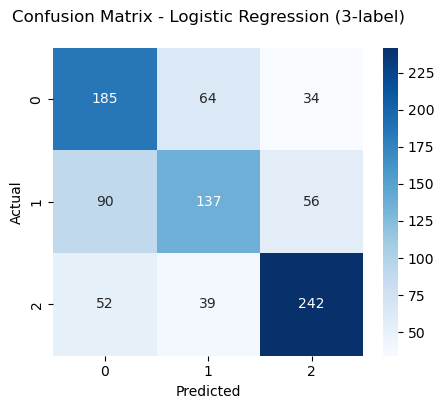

In [19]:
# Evaluate
print("\nLogistic Regression Accuracy (3-label):", acc_log_3)
print(classification_report(y_test, y_pred_log_3))

cm_log_3 = confusion_matrix(y_test, y_pred_log_3)
plt.figure(figsize=(5,4))
sns.heatmap(cm_log_3, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (3-label)\n')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
# Naive Bayes
nb_3 = MultinomialNB()
nb_3.fit(X_train_vec, y_train)
y_pred_nb_3 = nb_3.predict(X_test_vec)
acc_nb_3 = accuracy_score(y_test, y_pred_nb_3)


Naive Bayes Accuracy (3-label): 0.625139043381535
              precision    recall  f1-score   support

          -1       0.64      0.57      0.60       283
           0       0.61      0.42      0.50       283
           1       0.62      0.85      0.72       333

    accuracy                           0.63       899
   macro avg       0.62      0.61      0.61       899
weighted avg       0.62      0.63      0.61       899



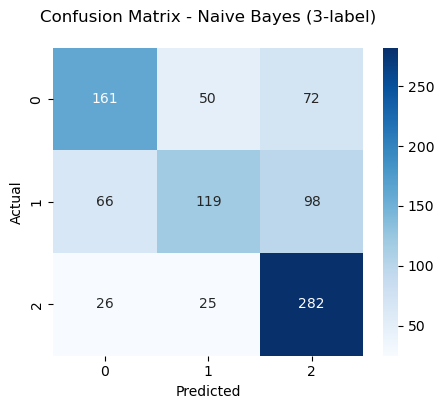

In [21]:
# Evaluate
print("\nNaive Bayes Accuracy (3-label):", acc_nb_3)
print(classification_report(y_test, y_pred_nb_3))

cm_nb_3 = confusion_matrix(y_test, y_pred_nb_3)
plt.figure(figsize=(5,4))
sns.heatmap(cm_nb_3, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes (3-label)\n')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
# Passive Aggressive
pac_3 = PassiveAggressiveClassifier(max_iter=1000,random_state=SEED)
pac_3.fit(X_train_vec, y_train)
y_pred_pac_3 = pac_3.predict(X_test_vec)
acc_pac_3 = accuracy_score(y_test, y_pred_pac_3)


Passive Aggressive Accuracy (3-label): 0.5995550611790879
              precision    recall  f1-score   support

          -1       0.54      0.64      0.58       283
           0       0.51      0.45      0.48       283
           1       0.73      0.69      0.71       333

    accuracy                           0.60       899
   macro avg       0.59      0.59      0.59       899
weighted avg       0.60      0.60      0.60       899



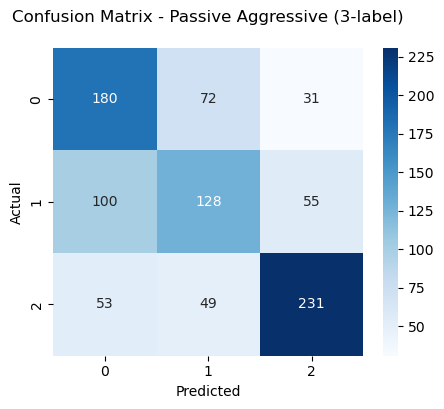

In [23]:
# Evaluate
print("\nPassive Aggressive Accuracy (3-label):", acc_pac_3)
print(classification_report(y_test, y_pred_pac_3))

cm_pac_3 = confusion_matrix(y_test, y_pred_pac_3)
plt.figure(figsize=(5,4))
sns.heatmap(cm_pac_3, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Passive Aggressive (3-label)\n')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [24]:
#SVM
svm_3 = LinearSVC(random_state=SEED, max_iter=10000)
svm_3.fit(X_train_vec, y_train)
y_pred_svm_3 = svm_3.predict(X_test_vec)
acc_svm_3 = accuracy_score(y_test, y_pred_svm_3)



SVM Accuracy (3-label): 0.6206896551724138
              precision    recall  f1-score   support

          -1       0.57      0.64      0.60       283
           0       0.56      0.48      0.52       283
           1       0.71      0.73      0.72       333

    accuracy                           0.62       899
   macro avg       0.61      0.61      0.61       899
weighted avg       0.62      0.62      0.62       899



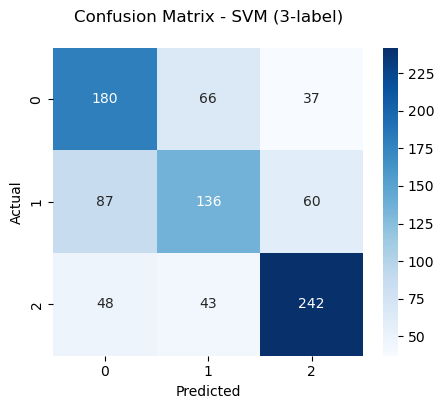

In [25]:
# Evaluate
print("\nSVM Accuracy (3-label):", acc_svm_3)
print(classification_report(y_test, y_pred_svm_3))

cm_svm_3 = confusion_matrix(y_test, y_pred_svm_3)
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm_3, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM (3-label)\n')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

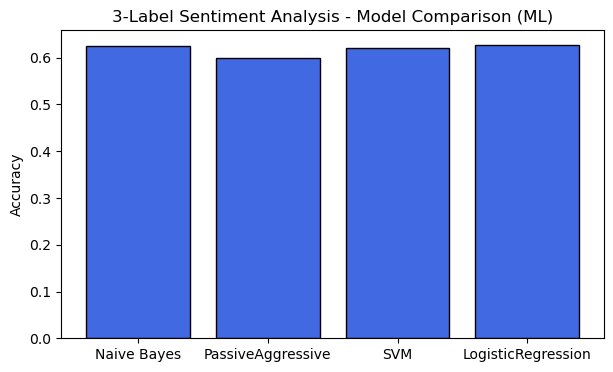

In [26]:
# Model Comparison Plot (3-label ML)
acc_3 = [
    acc_nb_3,
    acc_pac_3,
    acc_svm_3,
    acc_log_3
]
models_names_3 = ['Naive Bayes', 'PassiveAggressive', 'SVM', 'LogisticRegression']

plt.figure(figsize=(7,4))
plt.bar(models_names_3, acc_3, color='royalblue', edgecolor='black')
plt.ylabel('Accuracy')
plt.title('3-Label Sentiment Analysis - Model Comparison (ML)')
plt.show()


## Deep Learning Models: 3-label 


In [27]:
#  Deep Learning Prep:  BiLSTM, LSTM, RNN (3-label) 
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1

)


# Map original labels {-1, 0, 1} -> {0, 1, 2} for categorical crossentropy
label_to_idx = {-1: 0, 0: 1, 1: 2}
idx_to_label = {v: k for k, v in label_to_idx.items()}

y_train_idx = y_train.replace(label_to_idx)
y_test_idx  = y_test.replace(label_to_idx)

y_train_cat = to_categorical(y_train_idx)
y_test_cat  = to_categorical(y_test_idx)

# Shared tokenizer & padded sequences
MAX_VOCAB = 8000
MAX_LEN = 150

tokenizer_dl = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer_dl.fit_on_texts(X_train)

X_train_pad = pad_sequences(
    tokenizer_dl.texts_to_sequences(X_train),
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)

X_test_pad = pad_sequences(
    tokenizer_dl.texts_to_sequences(X_test),
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)

Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.4188 - loss: 1.0712 - val_accuracy: 0.4972 - val_loss: 1.0261 - learning_rate: 0.0010
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.5899 - loss: 0.8882 - val_accuracy: 0.5528 - val_loss: 0.9154 - learning_rate: 0.0010
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7652 - loss: 0.5677 - val_accuracy: 0.5639 - val_loss: 1.0688 - learning_rate: 0.0010
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8440 - loss: 0.3846
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.8633 - loss: 0.3571 - val_accuracy: 0.5694 - val_loss: 1.2064 - learning_rate: 0.0010
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9267 - loss: 0.2215 - val_accuracy: 0.5694 - val_loss: 1.3466 - learning_rate: 3.0000e-04
Epoch 6/30
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9272 - loss: 0.2086 
Epoch

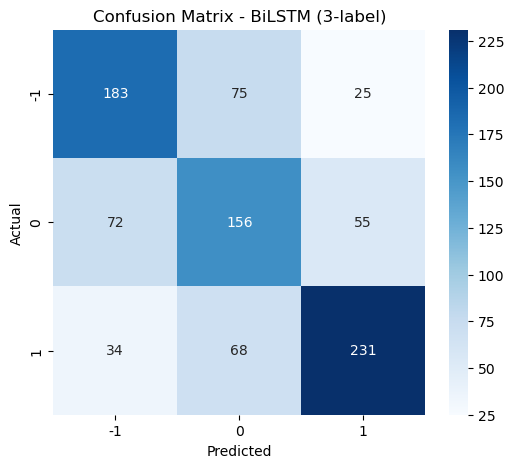

In [28]:
# BiLSTM Model (3-label) 


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

model_bilstm = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_bilstm.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_bilstm = model_bilstm.fit(
    X_train_pad, y_train_cat,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
)

loss_bilstm, acc_bilstm_3 = model_bilstm.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"\nBiLSTM Test Accuracy: {acc_bilstm_3:.4f}")

# Predictions
y_pred_probs = model_bilstm.predict(X_test_pad, verbose=0)
y_pred_idx = np.argmax(y_pred_probs, axis=1)
y_true_idx = np.argmax(y_test_cat, axis=1)

y_pred_labels = [idx_to_label[i] for i in y_pred_idx]
y_true_labels = [idx_to_label[i] for i in y_true_idx]

print("\nClassification Report (BiLSTM):\n")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

cm = confusion_matrix(y_true_labels, y_pred_labels)
labels = [-1, 0, 1]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BiLSTM (3-label)")
plt.show()


Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 699ms/step - accuracy: 0.3495 - loss: 1.1000 - val_accuracy: 0.4083 - val_loss: 1.0952 - learning_rate: 0.0010
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.3507 - loss: 1.0982 
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 704ms/step - accuracy: 0.3523 - loss: 1.0983 - val_accuracy: 0.3056 - val_loss: 1.0971 - learning_rate: 0.0010
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 699ms/step - accuracy: 0.3557 - loss: 1.0979 - val_accuracy: 0.4083 - val_loss: 1.0942 - learning_rate: 3.0000e-04
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.3824 - loss: 1.0959 
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 706ms/step - accuracy: 0.3659 - loss: 1.0973 - val_accuracy: 0.4083 - val_loss: 1.0936 - learning_rate: 3.0000e-04
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 716ms/step - accuracy: 0.3662 - lo

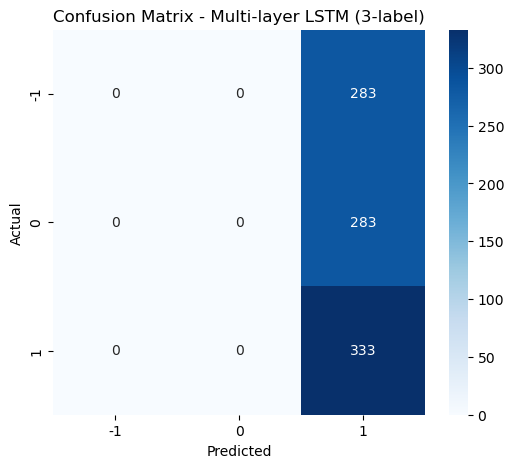

In [31]:
# LSTM (3-label)

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

model_lstm = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),

    # First LSTM layer (returns full sequence for stacking)
    LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),

    # Second LSTM layer (final representation)
    LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),

    # Dense layers
    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(3, activation='softmax')
])

model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

history_lstm = model_lstm.fit(
    X_train_pad, y_train_cat,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

loss_lstm, acc_lstm_3 = model_lstm.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"\nMulti-layer LSTM (3-label) Test Accuracy: {acc_lstm_3:.4f}")

# Predictions + Confusion Matrix
y_pred_probs_lstm = model_lstm.predict(X_test_pad, verbose=0)
y_pred_idx_lstm = np.argmax(y_pred_probs_lstm, axis=1)
y_true_idx_lstm = np.argmax(y_test_cat, axis=1)

y_pred_labels_lstm = [idx_to_label[i] for i in y_pred_idx_lstm]
y_true_labels_lstm = [idx_to_label[i] for i in y_true_idx_lstm]

print("\nClassification Report (Multi-layer LSTM - 3-label):\n")
print(classification_report(y_true_labels_lstm, y_pred_labels_lstm, digits=4))

cm_lstm = confusion_matrix(y_true_labels_lstm, y_pred_labels_lstm)
labels = [-1, 0, 1]

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_lstm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Multi-layer LSTM (3-label)")
plt.show()


Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.3347 - loss: 1.1562 - val_accuracy: 0.4083 - val_loss: 1.0958 - learning_rate: 0.0010
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3432 - loss: 1.1321
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3409 - loss: 1.1370 - val_accuracy: 0.3250 - val_loss: 1.1017 - learning_rate: 0.0010
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3393 - loss: 1.1302 - val_accuracy: 0.3333 - val_loss: 1.0961 - learning_rate: 3.0000e-04
Epoch 4/30
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3412 - loss: 1.1262
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3378 - loss: 1.1276 - val_accuracy: 0.2778 - val_loss: 1.1091 - learning_rate: 3.0000e-04
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3235 - loss: 1.1344 - v

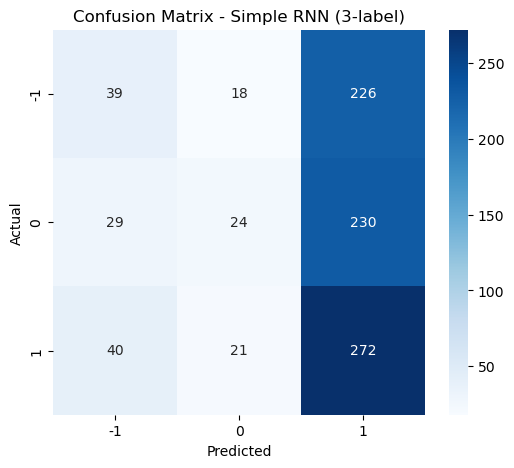

In [32]:
# Simple RNN Model (3-label) 


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

model_rnn = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=64, input_length=MAX_LEN),
    SimpleRNN(64, dropout=0.3, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_rnn.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

history_rnn = model_rnn.fit(
    X_train_pad, y_train_cat,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
)

loss_rnn, acc_rnn_3 = model_rnn.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"\nSimple RNN Test Accuracy: {acc_rnn_3:.4f}")

# Predictions & report (optional but nice)
y_pred_probs_rnn = model_rnn.predict(X_test_pad, verbose=0)
y_pred_idx_rnn = np.argmax(y_pred_probs_rnn, axis=1)
y_true_idx_rnn = np.argmax(y_test_cat, axis=1)

y_pred_labels_rnn = [idx_to_label[i] for i in y_pred_idx_rnn]
y_true_labels_rnn = [idx_to_label[i] for i in y_true_idx_rnn]

print("\nClassification Report (Simple RNN):\n")
print(classification_report(y_true_labels_rnn, y_pred_labels_rnn, digits=4))

cm_rnn = confusion_matrix(y_true_labels_rnn, y_pred_labels_rnn)
labels = [-1, 0, 1]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Simple RNN (3-label)")
plt.show()


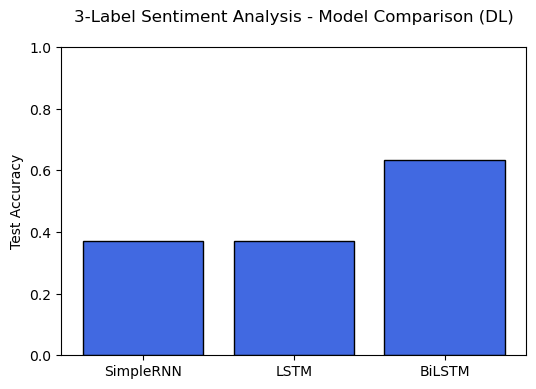

In [33]:
# Model Comparison  (3-Label DL)

accuracies_3 = [acc_rnn_3, acc_lstm_3, acc_bilstm_3]
model_names_3 = ['SimpleRNN', 'LSTM', 'BiLSTM']


plt.figure(figsize=(6, 4))
bars_3 = plt.bar(model_names_3, accuracies_3, color='royalblue', edgecolor='black')
plt.ylim(0, 1)
plt.ylabel('Test Accuracy')
plt.title('3-Label Sentiment Analysis - Model Comparison (DL)\n')
plt.show()



FINAL COMPARISON TABLE (3-Label)

              Model  Accuracy
             BiLSTM    0.6340
Logistic Regression    0.6274
        Naive Bayes    0.6251
                SVM    0.6207
 Passive Aggressive    0.5996
          SimpleRNN    0.3726
               LSTM    0.3704




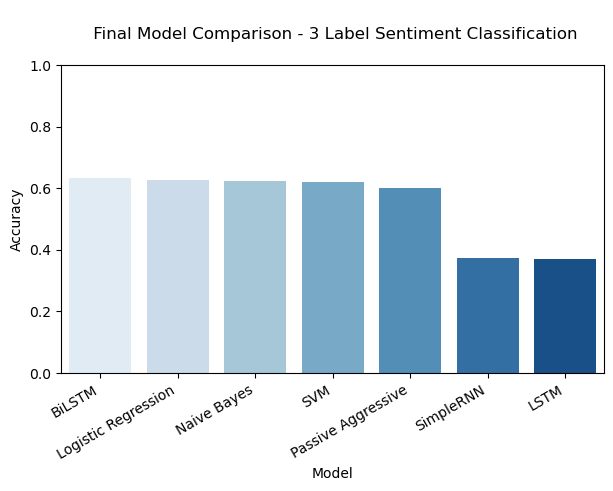

In [34]:
# FINAL COMPARISON TABLE (3-Label)

results_3 = pd.DataFrame({
    'Model': [
        'Naive Bayes', 'Passive Aggressive', 'SVM',
        'Logistic Regression', 'SimpleRNN', 'LSTM', 'BiLSTM'
    ],
    'Accuracy': [
        acc_nb_3, acc_pac_3, acc_svm_3,
        acc_log_3, acc_rnn_3, acc_lstm_3, acc_bilstm_3
    ]
})

# Format accuracy to 4 decimals
results_3['Accuracy'] = results_3['Accuracy'].astype(float).round(4)

# Sort by accuracy
results_3 = results_3.sort_values(by='Accuracy', ascending=False)

print("\nFINAL COMPARISON TABLE (3-Label)\n")
print(results_3.to_string(index=False))
print("\n")

plt.figure(figsize=(7,4))
sns.barplot(x='Model', y='Accuracy', data=results_3, palette='Blues')
plt.title('\n Final Model Comparison - 3 Label Sentiment Classification\n')
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1)
plt.show()


In [35]:
# 5-Fold Cross-Validation for all models (3-label classification)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

print("\n5-Fold Cross-Validation for all models (3-label classification)...\n")

# Helper functions
def generalization_comment(train_acc, val_acc, test_acc, threshold=0.05):
    """
    Simple heuristic to comment on overfitting / underfitting / good generalization.
    """
    if train_acc > val_acc + threshold and train_acc > test_acc + threshold:
        return ("The model appears to be overfitting: training accuracy is "
                "noticeably higher than validation/testing.")
    elif val_acc < 0.55 and test_acc < 0.55:
        return ("The model may be underfitting: both validation and testing "
                "performance are relatively low.")
    else:
        return ("The model seems to generalize well with balanced training, "
                "validation, and testing performance.")


def print_model_summary_block(
    name,
    train_acc_mean, train_acc_std, train_prec, train_rec, train_f1,
    val_acc, val_prec, val_rec, val_f1,
    test_acc, test_prec, test_rec, test_f1
):
    """
    Print metrics in the compact style used for reporting all models.
    """
    print(f"\n=============== {name} ===============\n")

    print("Training Performance (5-Fold CV):")
    print(f"Accuracy:  {train_acc_mean:.4f} ± {train_acc_std:.4f}")
    print(f"Precision: {train_prec:.4f}")
    print(f"Recall:    {train_rec:.4f}")
    print(f"F1-score:  {train_f1:.4f}\n")

    print("Validation Performance (5-Fold CV):")
    print(f"Accuracy:  {val_acc:.4f}")
    print(f"Precision: {val_prec:.4f}")
    print(f"Recall:    {val_rec:.4f}")
    print(f"F1-score:  {val_f1:.4f}\n")

    print("Testing Performance:")
    print(f"Accuracy:  {test_acc:.4f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"Recall:    {test_rec:.4f}")
    print(f"F1-score:  {test_f1:.4f}\n")

    comment = generalization_comment(train_acc_mean, val_acc, test_acc)
    print("", comment)


# 5-FOLD CV FOR CLASSICAL ML MODELS (3-LABEL) 

SEED = 42
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

ml_models = {
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=SEED),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(random_state=SEED, max_iter=10000),
    "Passive Aggressive": PassiveAggressiveClassifier(max_iter=1000, random_state=SEED)
}

for model_name, base_model in ml_models.items():
    train_fold_accs = []
    val_fold_accs   = []

    y_train_all      = []
    y_train_pred_all = []
    y_val_all        = []
    y_val_pred_all   = []

    # 5-fold CV on TRAIN split (X_train_vec, y_train)
    for tr_idx, val_idx in skf.split(X_train_vec, y_train):
        X_tr  = X_train_vec[tr_idx]
        X_val = X_train_vec[val_idx]
        y_tr  = y_train.iloc[tr_idx]
        y_val = y_train.iloc[val_idx]

        # fresh clone for each fold
        model = base_model.__class__(**base_model.get_params())
        model.fit(X_tr, y_tr)

        # Train predictions
        y_tr_pred  = model.predict(X_tr)
        # Val predictions
        y_val_pred = model.predict(X_val)

        train_acc = accuracy_score(y_tr, y_tr_pred)
        val_acc   = accuracy_score(y_val, y_val_pred)

        train_fold_accs.append(train_acc)
        val_fold_accs.append(val_acc)

        y_train_all.extend(y_tr.tolist())
        y_train_pred_all.extend(y_tr_pred.tolist())
        y_val_all.extend(y_val.tolist())
        y_val_pred_all.extend(y_val_pred.tolist())

    # Aggregated Training (5-fold)
    train_acc_mean = np.mean(train_fold_accs)
    train_acc_std  = np.std(train_fold_accs)

    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
        y_train_all, y_train_pred_all, average='weighted', zero_division=0
    )

    # Aggregated Validation (5-fold)
    val_acc = accuracy_score(y_val_all, y_val_pred_all)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
        y_val_all, y_val_pred_all, average='weighted', zero_division=0
    )

    # Testing Performance: fit on full TRAIN and eval on TEST
    final_model = base_model.__class__(**base_model.get_params())
    final_model.fit(X_train_vec, y_train)

    y_test_pred = final_model.predict(X_test_vec)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average='weighted', zero_division=0
    )

    # Pretty summary
    print_model_summary_block(
        model_name,
        train_acc_mean, train_acc_std, train_prec, train_rec, train_f1,
        val_acc, val_prec, val_rec, val_f1,
        test_acc, test_prec, test_rec, test_f1
    )


# 5-FOLD CV FOR DEEP LEARNING MODELS (3-LABEL) 

N_SPLITS = 5
skf_dl = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# Silent LR scheduler for CV 
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr_silent = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=0     
)

def build_rnn_model():
    model = Sequential([
        Embedding(input_dim=MAX_VOCAB, output_dim=64, input_length=MAX_LEN),
        SimpleRNN(64, dropout=0.3, recurrent_dropout=0.2),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
        LSTM(64, dropout=0.3, recurrent_dropout=0.2),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

def build_bilstm_model():
    model = Sequential([
        Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model


def cv_evaluate_dl_3label_existing(
    model_name,
    build_fn,          # builder for fresh fold models
    trained_model,     # already trained model on full X_train_pad
    X_train_pad, y_train_idx,
    X_test_pad,  y_test_idx
):
    """
    5-fold CV on the TRAINING set (X_train_pad, y_train_idx)
    + Test performance using an ALREADY-TRAINED model (trained_model).
    No new full-data training is done here.
    """
    train_fold_accs = []
    val_fold_accs   = []
    y_tr_all, y_tr_pred_all   = [], []
    y_val_all, y_val_pred_all = [], []

    for tr_idx, val_idx in skf_dl.split(X_train_pad, y_train_idx):
        X_tr_pad  = X_train_pad[tr_idx]
        X_val_pad = X_train_pad[val_idx]
        y_tr      = y_train_idx[tr_idx]
        y_val     = y_train_idx[val_idx]

        # One-hot labels
        y_tr_cat  = to_categorical(y_tr,  num_classes=3)
        y_val_cat = to_categorical(y_val, num_classes=3)

        # Fresh model per fold
        model = build_fn()

        model.fit(
            X_tr_pad, y_tr_cat,
            epochs=30,
            batch_size=64,
            validation_data=(X_val_pad, y_val_cat),
            callbacks=[early_stop, reduce_lr_silent],
            verbose=0
        )

        # Train predictions
        train_probs = model.predict(X_tr_pad, verbose=0)
        train_pred  = np.argmax(train_probs, axis=1)

        # Val predictions
        val_probs = model.predict(X_val_pad, verbose=0)
        val_pred  = np.argmax(val_probs, axis=1)

        train_acc = accuracy_score(y_tr,  train_pred)
        val_acc   = accuracy_score(y_val, val_pred)

        train_fold_accs.append(train_acc)
        val_fold_accs.append(val_acc)

        y_tr_all.extend(y_tr.tolist())
        y_tr_pred_all.extend(train_pred.tolist())
        y_val_all.extend(y_val.tolist())
        y_val_pred_all.extend(val_pred.tolist())

    # Aggregated Training (5-fold)
    train_acc_mean = np.mean(train_fold_accs)
    train_acc_std  = np.std(train_fold_accs)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
        y_tr_all, y_tr_pred_all, average='weighted', zero_division=0
    )

    # Aggregated Validation (5-fold)
    val_acc = accuracy_score(y_val_all, y_val_pred_all)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
        y_val_all, y_val_pred_all, average='weighted', zero_division=0
    )

    # Test performance using previously trained model
    test_probs    = trained_model.predict(X_test_pad, verbose=0)
    test_pred_idx = np.argmax(test_probs, axis=1)
    test_true_idx = y_test_idx

    test_acc = accuracy_score(test_true_idx, test_pred_idx)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
        test_true_idx, test_pred_idx, average='weighted', zero_division=0
    )

    # Summary
    print_model_summary_block(
        model_name,
        train_acc_mean, train_acc_std, train_prec, train_rec, train_f1,
        val_acc, val_prec, val_rec, val_f1,
        test_acc, test_prec, test_rec, test_f1
    )


# Run DL CV for all three deep models (3-label)
cv_evaluate_dl_3label_existing(
    "Simple RNN",
    build_rnn_model,
    model_rnn,
    X_train_pad, y_train_idx.values if hasattr(y_train_idx, 'values') else y_train_idx,
    X_test_pad,  y_test_idx.values if hasattr(y_test_idx, 'values') else y_test_idx
)

cv_evaluate_dl_3label_existing(
    "LSTM",
    build_lstm_model,
    model_lstm,
    X_train_pad, y_train_idx.values if hasattr(y_train_idx, 'values') else y_train_idx,
    X_test_pad,  y_test_idx.values if hasattr(y_test_idx, 'values') else y_test_idx
)

cv_evaluate_dl_3label_existing(
    "BiLSTM",
    build_bilstm_model,
    model_bilstm,
    X_train_pad, y_train_idx.values if hasattr(y_train_idx, 'values') else y_train_idx,
    X_test_pad,  y_test_idx.values if hasattr(y_test_idx, 'values') else y_test_idx
)



5-Fold Cross-Validation for all models (3-label classification)...


=============== Logistic Regression ===============

Training Performance (5-Fold CV):
Accuracy:  0.9073 ± 0.0011
Precision: 0.9082
Recall:    0.9073
F1-score:  0.9073

Validation Performance (5-Fold CV):
Accuracy:  0.5881
Precision: 0.5883
Recall:    0.5881
F1-score:  0.5860

Testing Performance:
Accuracy:  0.6274
Precision: 0.6278
Recall:    0.6274
F1-score:  0.6255

 The model appears to be overfitting: training accuracy is noticeably higher than validation/testing.

=============== Naive Bayes ===============

Training Performance (5-Fold CV):
Accuracy:  0.8788 ± 0.0030
Precision: 0.8837
Recall:    0.8788
F1-score:  0.8781

Validation Performance (5-Fold CV):
Accuracy:  0.5925
Precision: 0.5935
Recall:    0.5925
F1-score:  0.5796

Testing Performance:
Accuracy:  0.6251
Precision: 0.6245
Recall:    0.6251
F1-score:  0.6123

 The model appears to be overfitting: training accuracy is noticeably higher than validatio

## --------------------------------------- MODELING : Label 5 ---------------------------------------


In [55]:
# Features and labels
df = df_sentiment_5label.copy()
X_sentiment_label5 = df['clean_text'].astype(str)
y_sentiment_label5 = df['score']

In [56]:
# label mapping
label_map_5 = {-2: 0, -1: 1, 0: 2, 1: 3, 2: 4}
y_mapped_5 = y_sentiment_label5.map(label_map_5)

In [57]:
# Train-test split
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(
    X_sentiment_label5, y_mapped_5,
    test_size=0.2, random_state=SEED, stratify=y_mapped_5
)



# Targeted class weights (only -2 and 2)
train_dist_5 = y_train_5.value_counts(normalize=True).to_dict()
max_prop_5 = max(train_dist_5.values())

# Only upweight the two minority extremes: mapped 0 (-2) and 4 (+2)
rare_classes_mapped = [label_map_5[-2], label_map_5[2]]  # [0, 4]

class_weights_5 = {}
for cls, p in train_dist_5.items():
    if cls in rare_classes_mapped:
        # Amplify minority extremes relative to the max class
        class_weights_5[cls] = float(max_prop_5 / p)
    else:
       # Leave mid-range classes unchanged
       class_weights_5[cls] = 1.0

print("Targeted class weights (mapped labels):", class_weights_5)


Targeted class weights (mapped labels): {2: 1.0, 1: 1.0, 3: 1.0, 4: 2.9073482428115014, 0: 3.4732824427480913}


In [58]:
#TF-IDF Vectorization
vectorizer_5 = TfidfVectorizer(max_features=8000)
X_train_vec_5 = vectorizer_5.fit_transform(X_train_5)
X_test_vec_5 = vectorizer_5.transform(X_test_5)


## Classical ML Models


In [59]:
# Logistic Regression
logreg_5 = LogisticRegression(max_iter=200, random_state=SEED, class_weight=class_weights_5)
logreg_5.fit(X_train_vec_5, y_train_5)
y_pred_log_5 = logreg_5.predict(X_test_vec_5)
acc_log_5 = accuracy_score(y_test_5, y_pred_log_5)


Logistic Regression Accuracy (5-label): 0.4521
              precision    recall  f1-score   support

           0       0.29      0.48      0.36        65
           1       0.51      0.43      0.46       199
           2       0.50      0.61      0.55       228
           3       0.44      0.24      0.31       160
           4       0.40      0.47      0.43        78

    accuracy                           0.45       730
   macro avg       0.43      0.45      0.42       730
weighted avg       0.46      0.45      0.44       730



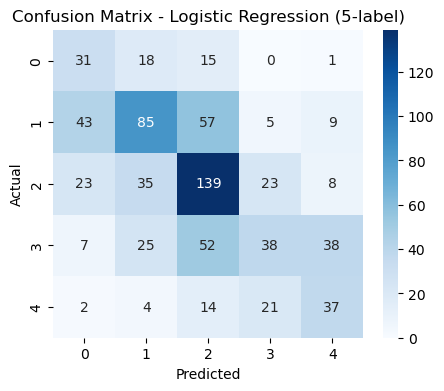

In [60]:
# Evaluate
print(f"\nLogistic Regression Accuracy (5-label): {acc_log_5:.4f}")
print(classification_report(y_test_5, y_pred_log_5))
cm_log_5 = confusion_matrix(y_test_5, y_pred_log_5)
plt.figure(figsize=(5,4))
sns.heatmap(cm_log_5, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (5-label)')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

In [61]:
# Naive Bayes
nb_5 = MultinomialNB()
nb_5.fit(X_train_vec_5, y_train_5)
y_pred_nb_5 = nb_5.predict(X_test_vec_5)
acc_nb_5 = accuracy_score(y_test_5, y_pred_nb_5)


Naive Bayes Accuracy (5-label): 0.4644
              precision    recall  f1-score   support

           0       0.75      0.05      0.09        65
           1       0.44      0.59      0.51       199
           2       0.47      0.68      0.56       228
           3       0.47      0.36      0.41       160
           4       0.56      0.06      0.11        78

    accuracy                           0.46       730
   macro avg       0.54      0.35      0.34       730
weighted avg       0.50      0.46      0.42       730



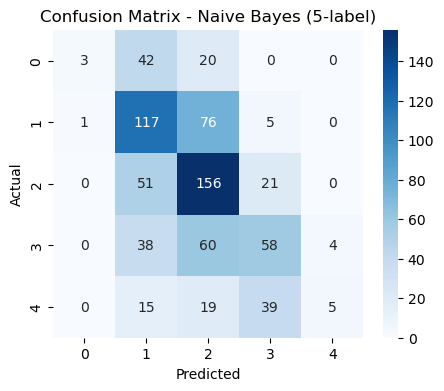

In [62]:
# Evaluate
print(f"\nNaive Bayes Accuracy (5-label): {acc_nb_5:.4f}")
print(classification_report(y_test_5, y_pred_nb_5))
cm_nb_5 = confusion_matrix(y_test_5, y_pred_nb_5)
plt.figure(figsize=(5,4))
sns.heatmap(cm_nb_5, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Naive Bayes (5-label)')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

In [63]:
# Passive Aggressive
pac_5 = PassiveAggressiveClassifier(max_iter=1000, random_state=SEED,  class_weight=class_weights_5)
pac_5.fit(X_train_vec_5, y_train_5)
y_pred_pac_5 = pac_5.predict(X_test_vec_5)
acc_pac_5 = accuracy_score(y_test_5, y_pred_pac_5)


Passive Aggressive Accuracy (5-label): 0.4274
              precision    recall  f1-score   support

           0       0.32      0.32      0.32        65
           1       0.46      0.43      0.44       199
           2       0.51      0.57      0.53       228
           3       0.36      0.33      0.34       160
           4       0.31      0.32      0.32        78

    accuracy                           0.43       730
   macro avg       0.39      0.39      0.39       730
weighted avg       0.42      0.43      0.42       730



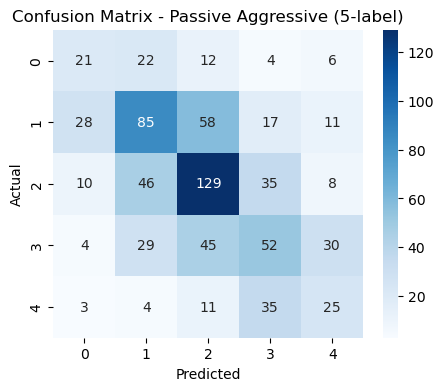

In [64]:
# Evaluate
print(f"\nPassive Aggressive Accuracy (5-label): {acc_pac_5:.4f}")
print(classification_report(y_test_5, y_pred_pac_5))
cm_pac_5 = confusion_matrix(y_test_5, y_pred_pac_5)
plt.figure(figsize=(5,4))
sns.heatmap(cm_pac_5, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Passive Aggressive (5-label)')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

In [65]:
# Linear SVM
svm_5 = LinearSVC(random_state=SEED, max_iter=10000,  class_weight=class_weights_5)
svm_5.fit(X_train_vec_5, y_train_5)
y_pred_svm_5 = svm_5.predict(X_test_vec_5)
acc_svm_5 = accuracy_score(y_test_5, y_pred_svm_5)


SVM Accuracy (5-label): 0.4548
              precision    recall  f1-score   support

           0       0.31      0.40      0.35        65
           1       0.49      0.46      0.48       199
           2       0.51      0.57      0.54       228
           3       0.43      0.35      0.39       160
           4       0.36      0.36      0.36        78

    accuracy                           0.45       730
   macro avg       0.42      0.43      0.42       730
weighted avg       0.46      0.45      0.45       730



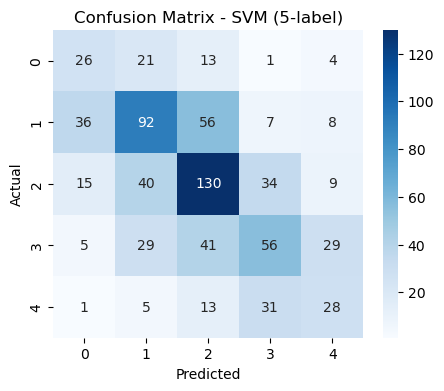

In [66]:
# Evaluate
print(f"\nSVM Accuracy (5-label): {acc_svm_5:.4f}")
print(classification_report(y_test_5, y_pred_svm_5))
cm_svm_5 = confusion_matrix(y_test_5, y_pred_svm_5)
plt.figure(figsize=(5,4))
sns.heatmap(cm_svm_5, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM (5-label)')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

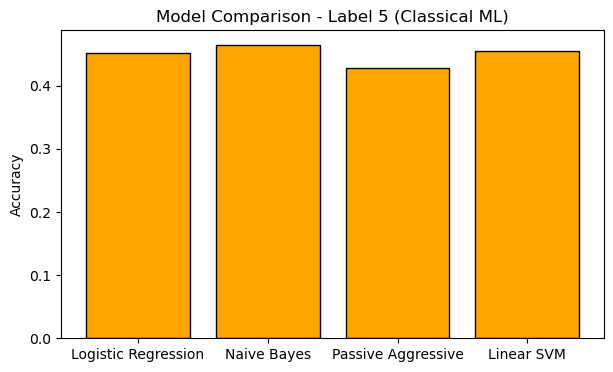

In [67]:
# Model Comparison (ML Models)
acc_5 = [acc_log_5, acc_nb_5, acc_pac_5, acc_svm_5]
models_5 = ['Logistic Regression', 'Naive Bayes', 'Passive Aggressive', 'Linear SVM']

plt.figure(figsize=(7,4))
plt.bar(models_5, acc_5, color='orange', edgecolor='black')
plt.ylabel('Accuracy')
plt.title('Model Comparison - Label 5 (Classical ML)')
plt.show()


## Deep Learning Models 


In [69]:
# Deep Learning Prep (5-label)

from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Config
NUM_CLASSES_5 = 5
MAX_VOCAB_5   = 8000      
MAX_LEN_5     = 150       
EPOCHS_5      = 20
BATCH_SIZE_5  = 64

# One-hot labels
y_train_cat_5 = to_categorical(y_train_5, num_classes=NUM_CLASSES_5)
y_test_cat_5  = to_categorical(y_test_5,  num_classes=NUM_CLASSES_5)

# Single shared tokenizer
tokenizer_5 = Tokenizer(num_words=MAX_VOCAB_5, oov_token="<OOV>")
tokenizer_5.fit_on_texts(X_train_5)

X_train_pad_5 = pad_sequences(
    tokenizer_5.texts_to_sequences(X_train_5),
    maxlen=MAX_LEN_5,
    padding="post",
    truncating="post"
)
X_test_pad_5 = pad_sequences(
    tokenizer_5.texts_to_sequences(X_test_5),
    maxlen=MAX_LEN_5,
    padding="post",
    truncating="post"
)

classes_5 = np.unique(y_train_5)

# Class distribution in the TRAIN set
counter_5 = Counter(y_train_5)
print("Train class counts (mapped labels):", counter_5)

max_freq_5 = max(counter_5.values())

# Initialize all weights to 1.0
class_weights_5 = {int(c): 1.0 for c in classes_5}

# Boost only minority classes: 0 (score -2), 4 (score 2)
class_weights_5[0] = max_freq_5 / counter_5[0]   # weight for -2
class_weights_5[4] = max_freq_5 / counter_5[4]   # weight for  2

print("Targeted class weights (mapped labels):", class_weights_5)


# Callbacks (5-label)
early_stop_5 = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="max",
    restore_best_weights=True
)

reduce_lr_5 = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=0
)


Train class counts (mapped labels): Counter({2: 910, 1: 793, 3: 641, 4: 313, 0: 262})
Targeted class weights (mapped labels): {0: 3.4732824427480917, 1: 1.0, 2: 1.0, 3: 1.0, 4: 2.9073482428115014}



BiLSTM (5-label) Test Accuracy: 0.5000

Classification Report (BiLSTM - 5-label):

              precision    recall  f1-score   support

          -2     0.4857    0.5231    0.5037        65
          -1     0.4703    0.5176    0.4928       199
           0     0.5644    0.5570    0.5607       228
           1     0.4519    0.3812    0.4136       160
           2     0.4938    0.5128    0.5031        78

    accuracy                         0.5000       730
   macro avg     0.4932    0.4984    0.4948       730
weighted avg     0.4996    0.5000    0.4987       730



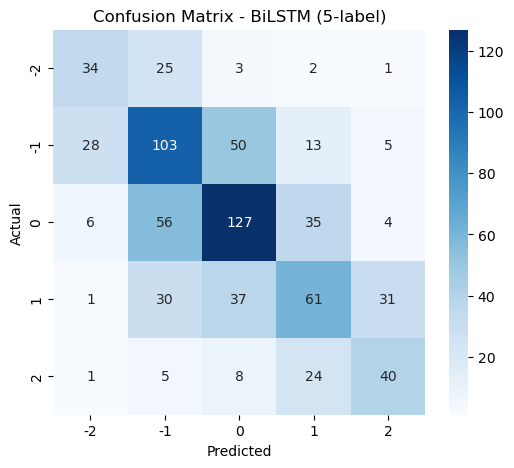

In [70]:
# BiLSTM Model (5-label)

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

model_bilstm_5 = Sequential([
    Embedding(input_dim=MAX_VOCAB_5, output_dim=128, input_length=MAX_LEN_5),
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES_5, activation='softmax')
])

model_bilstm_5.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

history_bilstm_5 = model_bilstm_5.fit(
    X_train_pad_5, y_train_cat_5,
    epochs=EPOCHS_5,
    batch_size=BATCH_SIZE_5,
    validation_split=0.1,
    callbacks=[early_stop_5, reduce_lr_5],
    class_weight=class_weights_5,
    shuffle=True,           
    verbose=0
)

loss_bilstm_5, acc_bilstm_5 = model_bilstm_5.evaluate(X_test_pad_5, y_test_cat_5, verbose=0)
print(f"\nBiLSTM (5-label) Test Accuracy: {acc_bilstm_5:.4f}")

# Predictions & decoding
y_pred_probs_5 = model_bilstm_5.predict(X_test_pad_5, verbose=0)
y_pred_idx_5   = np.argmax(y_pred_probs_5, axis=1)
y_true_idx_5   = np.argmax(y_test_cat_5, axis=1)

reverse_label_map_5 = {v: k for k, v in label_map_5.items()}
y_pred_labels_5 = [reverse_label_map_5[i] for i in y_pred_idx_5]
y_true_labels_5 = [reverse_label_map_5[i] for i in y_true_idx_5]

print("\nClassification Report (BiLSTM - 5-label):\n")
print(classification_report(y_true_labels_5, y_pred_labels_5, digits=4))

cm_bilstm_5 = confusion_matrix(y_true_labels_5, y_pred_labels_5)
labels_5 = sorted(label_map_5.keys())

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_bilstm_5, annot=True, fmt='d', cmap='Blues',
    xticklabels=labels_5, yticklabels=labels_5
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BiLSTM (5-label)")
plt.show()



Simple RNN (5-label) Test Accuracy: 0.3123

Classification Report (Simple RNN - 5-label):

              precision    recall  f1-score   support

          -2     0.0000    0.0000    0.0000        65
          -1     0.0000    0.0000    0.0000       199
           0     0.3123    1.0000    0.4760       228
           1     0.0000    0.0000    0.0000       160
           2     0.0000    0.0000    0.0000        78

    accuracy                         0.3123       730
   macro avg     0.0625    0.2000    0.0952       730
weighted avg     0.0975    0.3123    0.1487       730



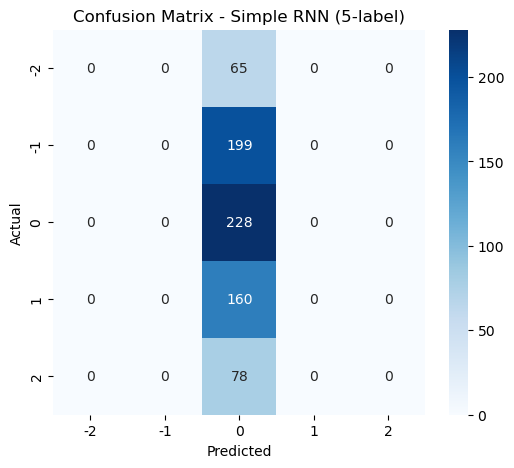

In [76]:
# Simple RNN Model (5-label)

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

model_rnn_5 = Sequential([
    Embedding(input_dim=MAX_VOCAB_5, output_dim=64, input_length=MAX_LEN_5),
    SimpleRNN(64, dropout=0.3, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES_5, activation='softmax')
])

model_rnn_5.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

history_rnn_5 = model_rnn_5.fit(
    X_train_pad_5, y_train_cat_5,
    epochs=EPOCHS_5,
    batch_size=BATCH_SIZE_5,
    validation_split=0.1,
    callbacks=[early_stop_5, reduce_lr_5],
    class_weight=class_weights_5,
    shuffle=True,        
    verbose=0
)

loss_rnn_5, acc_rnn_5 = model_rnn_5.evaluate(X_test_pad_5, y_test_cat_5, verbose=0)
print(f"\nSimple RNN (5-label) Test Accuracy: {acc_rnn_5:.4f}")

# Predictions & decoding
y_pred_probs_rnn_5 = model_rnn_5.predict(X_test_pad_5, verbose=0)
y_pred_idx_rnn_5   = np.argmax(y_pred_probs_rnn_5, axis=1)
y_true_idx_rnn_5   = np.argmax(y_test_cat_5, axis=1)

y_pred_labels_rnn_5 = [reverse_label_map_5[i] for i in y_pred_idx_rnn_5]
y_true_labels_rnn_5 = [reverse_label_map_5[i] for i in y_true_idx_rnn_5]

print("\nClassification Report (Simple RNN - 5-label):\n")
print(classification_report(y_true_labels_rnn_5, y_pred_labels_rnn_5, digits=4))

cm_rnn_5 = confusion_matrix(y_true_labels_rnn_5, y_pred_labels_rnn_5)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_rnn_5, annot=True, fmt='d', cmap='Blues',
    xticklabels=labels_5, yticklabels=labels_5
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Simple RNN (5-label)")
plt.show()



Multi-layer LSTM (5-label) Test Accuracy: 0.1068

Classification Report (Multi-layer LSTM - 5-label):

              precision    recall  f1-score   support

          -2     0.0000    0.0000    0.0000        65
          -1     0.0000    0.0000    0.0000       199
           0     0.0000    0.0000    0.0000       228
           1     0.0000    0.0000    0.0000       160
           2     0.1068    1.0000    0.1931        78

    accuracy                         0.1068       730
   macro avg     0.0214    0.2000    0.0386       730
weighted avg     0.0114    0.1068    0.0206       730



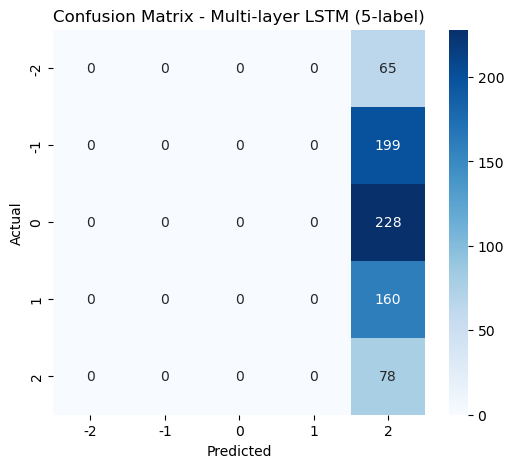

In [77]:
# LSTM (5-label)

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

model_lstm_5 = Sequential([
    Embedding(input_dim=MAX_VOCAB_5, output_dim=128, input_length=MAX_LEN_5),

    LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(NUM_CLASSES_5, activation='softmax')
])

model_lstm_5.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

history_lstm_5 = model_lstm_5.fit(
    X_train_pad_5, y_train_cat_5,
    epochs=EPOCHS_5,
    batch_size=BATCH_SIZE_5,
    validation_split=0.1,
    callbacks=[early_stop_5, reduce_lr_5],
    class_weight=class_weights_5,
    shuffle=True,
    verbose=0
)

loss_lstm_5, acc_lstm_5 = model_lstm_5.evaluate(X_test_pad_5, y_test_cat_5, verbose=0)
print(f"\nMulti-layer LSTM (5-label) Test Accuracy: {acc_lstm_5:.4f}")

# Predictions + decoding
y_prob_lstm_5 = model_lstm_5.predict(X_test_pad_5, verbose=0)
y_pred_idx_5  = np.argmax(y_prob_lstm_5, axis=1)
y_true_idx_5  = np.argmax(y_test_cat_5, axis=1)

y_pred_labels_5 = [reverse_label_map_5[i] for i in y_pred_idx_5]
y_true_labels_5 = [reverse_label_map_5[i] for i in y_true_idx_5]

print("\nClassification Report (Multi-layer LSTM - 5-label):\n")
print(classification_report(y_true_labels_5, y_pred_labels_5, digits=4))

cm_lstm_5 = confusion_matrix(y_true_labels_5, y_pred_labels_5)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_lstm_5,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels_5,
    yticklabels=labels_5
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Multi-layer LSTM (5-label)")
plt.show()


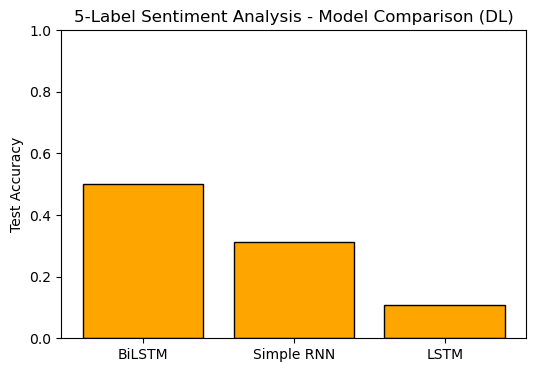

In [78]:
#  DL Model Comparison 

# Accuracy values from both models
accuracies = [acc_bilstm_5, acc_rnn_5, acc_lstm_5]  
model_names = ['BiLSTM', 'Simple RNN', 'LSTM']

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(model_names, accuracies, color='orange', edgecolor='black')
plt.ylim(0, 1)
plt.ylabel('Test Accuracy')
plt.title('5-Label Sentiment Analysis - Model Comparison (DL)')

plt.show()



Final Model Comparison (5-Label):

              Model Accuracy
             BiLSTM   0.5000
        Naive Bayes   0.4644
         Linear SVM   0.4548
Logistic Regression   0.4521
 Passive Aggressive   0.4274
         Simple RNN   0.3123
               LSTM   0.1068


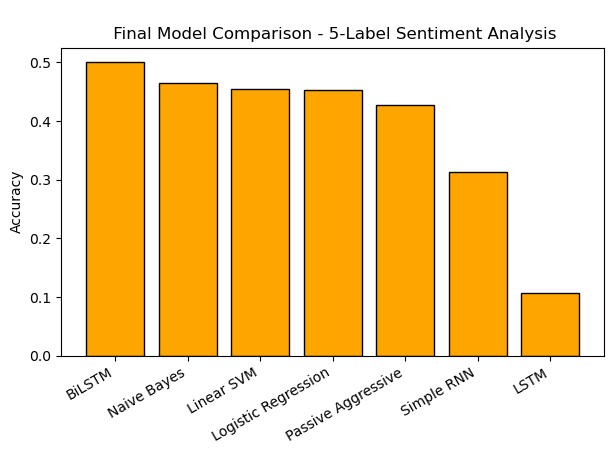

In [79]:
# FINAL COMPARISON TABLE (5-Label)

model_names_5 = [
    'Logistic Regression',
    'Naive Bayes',
    'Passive Aggressive',
    'Linear SVM',
    'Simple RNN',
    'BiLSTM',
    'LSTM'
]

accuracies_5 = [
    acc_log_5, acc_nb_5, acc_pac_5, acc_svm_5,
    acc_rnn_5, acc_bilstm_5, acc_lstm_5
]

# format to 4 decimals
comparison_df_5 = pd.DataFrame({
    'Model': model_names_5,
    'Accuracy': accuracies_5
})

# Sort by accuracy
comparison_df_5 = comparison_df_5.sort_values(by='Accuracy', ascending=False)

# Format accuracy to 4 decimals
comparison_df_5['Accuracy'] = comparison_df_5['Accuracy'].apply(lambda x: f"{x:.4f}")

print("\nFinal Model Comparison (5-Label):\n")
print(comparison_df_5.to_string(index=False))

# Plot
plt.figure(figsize=(7,4))
plt.bar(comparison_df_5['Model'], comparison_df_5['Accuracy'].astype(float),
        color='orange', edgecolor='black')
plt.ylabel('Accuracy')
plt.title('\n Final Model Comparison - 5-Label Sentiment Analysis')
plt.xticks(rotation=30, ha='right')
plt.show()


In [82]:
# 5-Fold Cross-Validation for all models (5-label classification)

from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

print("\n5-Fold Cross-Validation for all models (5-label classification)...\n")

# Helper functions
def generalization_comment(train_acc, val_acc, test_acc, threshold=0.08):
    """
    Simple heuristic to comment on overfitting / underfitting / generalization.
    """
    if train_acc > val_acc + threshold and train_acc > test_acc + threshold:
        return ("The model appears to be overfitting: training accuracy is "
                "noticeably higher than validation/testing.")
    elif val_acc < 0.50 and test_acc < 0.50:
        return ("The model may be underfitting: both validation and testing "
                "performance are relatively low.")
    else:
        return ("The model seems to generalize well with balanced training, "
                "validation, and testing performance.")

def print_model_summary_block(
    name,
    train_acc_mean, train_acc_std, train_prec, train_rec, train_f1,
    val_acc, val_prec, val_rec, val_f1,
    test_acc, test_prec, test_rec, test_f1
):
    """
    Pretty printed block matching the 3-label version.
    """
    print(f"\n=============== {name} ===============\n")

    print("Training Performance (5-Fold CV):")
    print(f"Accuracy:  {train_acc_mean:.4f} ± {train_acc_std:.4f}")
    print(f"Precision: {train_prec:.4f}")
    print(f"Recall:    {train_rec:.4f}")
    print(f"F1-score:  {train_f1:.4f}\n")

    print("Validation Performance (5-Fold CV):")
    print(f"Accuracy:  {val_acc:.4f}")
    print(f"Precision: {val_prec:.4f}")
    print(f"Recall:    {val_rec:.4f}")
    print(f"F1-score:  {val_f1:.4f}\n")

    print("Testing Performance:")
    print(f"Accuracy:  {test_acc:.4f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"Recall:    {test_rec:.4f}")
    print(f"F1-score:  {test_f1:.4f}\n")

    print("", generalization_comment(train_acc_mean, val_acc, test_acc))


# 5-FOLD CV FOR CLASSICAL ML MODELS (5-LABEL)
SEED = 42
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

ml_models_5 = {
    "Logistic Regression": LogisticRegression(
        max_iter=200, random_state=SEED, class_weight=class_weights_dict_5),
    "Naive Bayes": MultinomialNB(),   # NB does NOT support class_weight
    "Linear SVM": LinearSVC(
        random_state=SEED, max_iter=10000, class_weight=class_weights_dict_5),
    "Passive Aggressive": PassiveAggressiveClassifier(
        max_iter=1000, random_state=SEED, class_weight=class_weights_dict_5)
}

for model_name, base_model in ml_models_5.items():

    train_fold_accs, val_fold_accs = [], []
    y_train_all, y_train_pred_all = [], []
    y_val_all,   y_val_pred_all   = [], []

    for tr_idx, val_idx in skf.split(X_train_vec_5, y_train_5):

        X_tr = X_train_vec_5[tr_idx]
        X_val = X_train_vec_5[val_idx]
        y_tr = y_train_5.iloc[tr_idx]
        y_val = y_train_5.iloc[val_idx]

        # fresh clone
        model = base_model.__class__(**base_model.get_params())
        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        train_fold_accs.append(accuracy_score(y_tr, y_tr_pred))
        val_fold_accs.append(accuracy_score(y_val, y_val_pred))

        y_train_all.extend(y_tr.tolist())
        y_train_pred_all.extend(y_tr_pred.tolist())
        y_val_all.extend(y_val.tolist())
        y_val_pred_all.extend(y_val_pred.tolist())

    # aggregated train
    train_acc_mean = np.mean(train_fold_accs)
    train_acc_std  = np.std(train_fold_accs)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
        y_train_all, y_train_pred_all, average="weighted", zero_division=0)

    # aggregated validation
    val_acc = accuracy_score(y_val_all, y_val_pred_all)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
        y_val_all, y_val_pred_all, average="weighted", zero_division=0)

    # test on full train
    final_model = base_model.__class__(**base_model.get_params())
    final_model.fit(X_train_vec_5, y_train_5)
    y_test_pred = final_model.predict(X_test_vec_5)

    test_acc = accuracy_score(y_test_5, y_test_pred)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
        y_test_5, y_test_pred, average="weighted", zero_division=0
    )

    print_model_summary_block(
        model_name,
        train_acc_mean, train_acc_std, train_prec, train_rec, train_f1,
        val_acc, val_prec, val_rec, val_f1,
        test_acc, test_prec, test_rec, test_f1,
    )


# 5-FOLD CV FOR DEEP LEARNING MODELS (5-LABEL)
N_SPLITS = 5
skf_dl = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

reduce_lr_silent_5 = ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=0
)


def build_rnn_5():
    model = Sequential([
        Embedding(input_dim=MAX_VOCAB_5, output_dim=64, input_length=MAX_LEN_5),
        SimpleRNN(64, dropout=0.3, recurrent_dropout=0.2),
        Dense(32, activation="relu"),
        Dropout(0.3),
        Dense(NUM_CLASSES_5, activation="softmax")
    ])
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=1e-3),
        metrics=["accuracy"]
    )
    return model


def build_lstm_5():
    model = Sequential([
        Embedding(input_dim=MAX_VOCAB_5, output_dim=128, input_length=MAX_LEN_5),
        LSTM(64, dropout=0.3, recurrent_dropout=0.2),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(NUM_CLASSES_5, activation="softmax")
    ])
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=1e-3),
        metrics=["accuracy"]
    )
    return model


def build_bilstm_5():
    model = Sequential([
        Embedding(input_dim=MAX_VOCAB_5, output_dim=128, input_length=MAX_LEN_5),
        Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),
        Dropout(0.4),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(NUM_CLASSES_5, activation="softmax")
    ])
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=1e-3),
        metrics=["accuracy"]
    )
    return model


def cv_evaluate_dl_5label(
    model_name,
    build_fn,
    trained_model,
    X_train_pad_5,
    y_train_5,
    X_test_pad_5,
    y_test_5
):
    train_fold_accs, val_fold_accs = [], []
    y_tr_all, y_tr_pred_all = [], []
    y_val_all, y_val_pred_all = [], []

    for tr_idx, val_idx in skf_dl.split(X_train_pad_5, y_train_5):

        X_tr_pad = X_train_pad_5[tr_idx]
        X_val_pad = X_train_pad_5[val_idx]
        y_tr = y_train_5[tr_idx]
        y_val = y_train_5[val_idx]

        y_tr_cat = to_categorical(y_tr, num_classes=5)
        y_val_cat = to_categorical(y_val, num_classes=5)

        model = build_fn()

        model.fit(
            X_tr_pad, y_tr_cat,
            epochs=20,
            batch_size=64,
            validation_data=(X_val_pad, y_val_cat),
            class_weight=class_weights_5,
            callbacks=[early_stop_5, reduce_lr_silent_5],
            verbose=0
        )

        # train pred
        p_tr = np.argmax(model.predict(X_tr_pad, verbose=0), axis=1)
        p_val = np.argmax(model.predict(X_val_pad, verbose=0), axis=1)

        train_fold_accs.append(accuracy_score(y_tr, p_tr))
        val_fold_accs.append(accuracy_score(y_val, p_val))

        y_tr_all.extend(y_tr.tolist())
        y_tr_pred_all.extend(p_tr.tolist())
        y_val_all.extend(y_val.tolist())
        y_val_pred_all.extend(p_val.tolist())

    # aggregated metrics
    train_acc_mean = np.mean(train_fold_accs)
    train_acc_std  = np.std(train_fold_accs)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
        y_tr_all, y_tr_pred_all, average="weighted", zero_division=0
    )

    val_acc = accuracy_score(y_val_all, y_val_pred_all)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
        y_val_all, y_val_pred_all, average="weighted", zero_division=0
    )

    # Test using previously trained full model
    test_probs = trained_model.predict(X_test_pad_5, verbose=0)
    test_pred = np.argmax(test_probs, axis=1)

    test_acc = accuracy_score(y_test_5, test_pred)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
        y_test_5, test_pred, average="weighted", zero_division=0
    )

    print_model_summary_block(
        model_name,
        train_acc_mean, train_acc_std, train_prec, train_rec, train_f1,
        val_acc, val_prec, val_rec, val_f1,
        test_acc, test_prec, test_rec, test_f1,
    )


# Run DL 5-fold CV (5-label)
cv_evaluate_dl_5label("Simple RNN", build_rnn_5, model_rnn_5,
                      X_train_pad_5, y_train_5.values, X_test_pad_5, y_test_5.values)

cv_evaluate_dl_5label("LSTM", build_lstm_5, model_lstm_5,
                      X_train_pad_5, y_train_5.values, X_test_pad_5, y_test_5.values)

cv_evaluate_dl_5label("BiLSTM", build_bilstm_5, model_bilstm_5,
                      X_train_pad_5, y_train_5.values, X_test_pad_5, y_test_5.values)



5-Fold Cross-Validation for all models (5-label classification)...


=============== Logistic Regression ===============

Training Performance (5-Fold CV):
Accuracy:  0.8556 ± 0.0037
Precision: 0.8633
Recall:    0.8556
F1-score:  0.8563

Validation Performance (5-Fold CV):
Accuracy:  0.4608
Precision: 0.4643
Recall:    0.4608
F1-score:  0.4607

Testing Performance:
Accuracy:  0.4548
Precision: 0.4608
Recall:    0.4548
F1-score:  0.4546

 The model appears to be overfitting: training accuracy is noticeably higher than validation/testing.

=============== Naive Bayes ===============

Training Performance (5-Fold CV):
Accuracy:  0.7372 ± 0.0044
Precision: 0.7742
Recall:    0.7372
F1-score:  0.6907

Validation Performance (5-Fold CV):
Accuracy:  0.4560
Precision: 0.5107
Recall:    0.4560
F1-score:  0.4117

Testing Performance:
Accuracy:  0.4644
Precision: 0.4980
Recall:    0.4644
F1-score:  0.4223

 The model appears to be overfitting: training accuracy is noticeably higher than validatio